In [1]:
import numpy as np
import pandas as pd

from data_process import *
from data_split import *

In [13]:
def get_specific_data(root_path, by_txt=True, activity='dig', dis='1.0', num=None):
    """具体取出某距离上发生的某事件信号
    """
    data_root, txt_root = root_path + '/data', root_path + '/txt'
    total_activity = []
    file_name_list = [name for name in os.listdir(data_root) if activity in name and dis in name]

    for file_name in file_name_list:
        file_path = data_root + '/' + file_name
        dataXYZ = pd.read_csv(file_path, header= 0)
        data_x, data_y, data_z = list(dataXYZ.iloc[:,0]), list(dataXYZ.iloc[:, 1]), list(dataXYZ.iloc[:, 2])
        base_value = cal_base_value(dataXYZ, 32, 16, 500)
        
        if by_txt: # 获取 activity_list
            txt_path = txt_root + '/' + file_name[:-3] + 'txt'
            with open(txt_path, 'r') as f:
                activity_list = f.readlines()
            activity_list = [int(activity[:-1]) for activity in activity_list]
        else:
            activity_list = [int(np.mean(idx)) for idx in activitySplit(dataXYZ, 32, 16, 500)]

        noise_list = [index-128 for index in activity_list]
        activity_list = [{'data_x': np.array(extract_data_from_center(data_x, center, base_value[0])),
                        'data_y': np.array(extract_data_from_center(data_y, center, base_value[1])),
                        'data_z': np.array(extract_data_from_center(data_z, center, base_value[2])),
                        'noise_x': np.array(extract_data_from_center(data_x, center-128, base_value[0])),
                        'noise_y': np.array(extract_data_from_center(data_y, center-128, base_value[1])),
                        'noise_z': np.array(extract_data_from_center(data_z, center-128, base_value[2])),
                        'label': get_activity_label(file_name), 'file_name': file_name, 'base_value':base_value,
                        'angle': cal_angles(base_value), 'area': get_area_label(data_root)} 
                        for center in activity_list]
        
        total_activity += activity_list

    if num is not None:
        return random.choices(total_activity, k=num)
    else:
        return total_activity

In [141]:
root = 'E:/研一/嗑盐/土壤扰动/dataset/zyq'
# zwy2_dig = get_specific_data(root, by_txt=False, activity='dig', dis='5.0')
zyq_dig = get_specific_data(root, by_txt=False)

In [147]:
file_path = 'E:/研一/嗑盐/土壤扰动/dataset/zyq/data/dig_1.0_A.csv'
dataXYZ = pd.read_csv(file_path, header= 0)
data_x, data_y, data_z = list(dataXYZ.iloc[:,0]), list(dataXYZ.iloc[:, 1]), list(dataXYZ.iloc[:, 2])

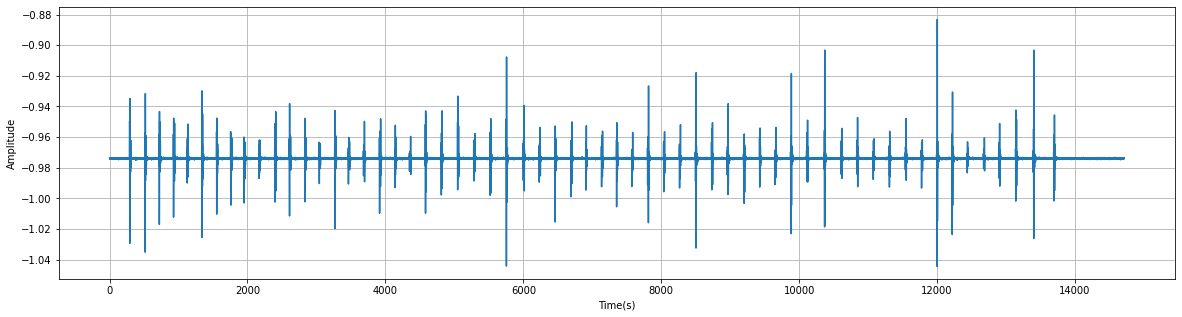

In [148]:
plot_time(data_z)

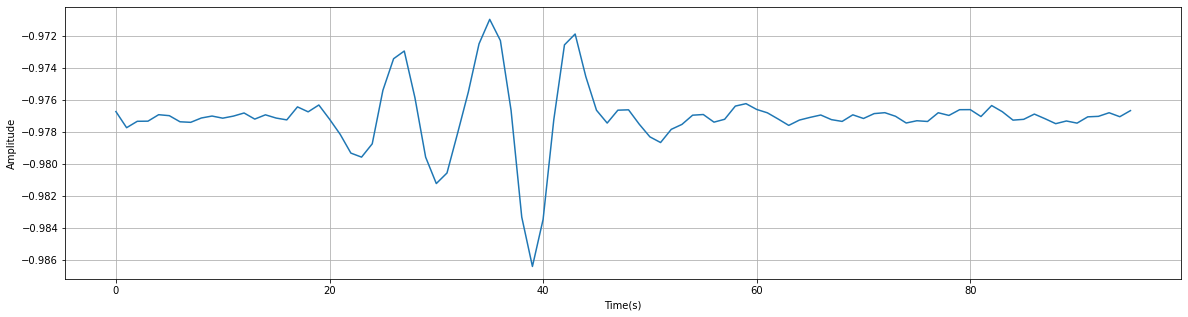

In [139]:
plot_time(zwy2_dig[13]['data_z'])

In [138]:
sig = zwy2_dig[13]
s = sig['data_z'] - sig['base_value'][2]
n = sig['noise_z'] - sig['base_value'][2]
cal_snr(s, n)

67.7064452741073

In [104]:
cal_snr(s, n)

65.54621180625072

0.9999797992931184

In [149]:
def generate_data(root_path, by_txt=True, shuffle=True, factor=0.2):
    """
    根据打好标签的 txt 文件导入数据，并按文件来划分训练集以及测试集
    其中训练集，测试集默认按 0.8 0.2 比例划分
    数据集目录结构：area/data/, area/txt/
    """
    data_root, txt_root = root_path + '/data', root_path + '/txt'
    train_data, test_data = [], []
    file_data_dict = {}

    file_name_list = os.listdir(data_root)

    for file_name in file_name_list:
        
        file_path = data_root + '/' + file_name
        
        dataXYZ = pd.read_csv(file_path, header= 0)
        data_x, data_y, data_z = list(dataXYZ.iloc[:,0]), list(dataXYZ.iloc[:, 1]), list(dataXYZ.iloc[:, 2])
        base_value = cal_base_value(dataXYZ, 32, 16, 500)
        
        if by_txt:
            txt_path = txt_root + '/' + file_name[:-3] + 'txt'
            with open(txt_path, 'r') as f:
                activity_list = f.readlines()
            activity_list = [int(activity[:-1]) for activity in activity_list]
        else:
            activity_list = [int(np.mean(idx)) for idx in activitySplit(dataXYZ, 32, 16, 500)]

        new_list = []
        for center in activity_list:
            item = {'data_x': np.array(extract_data_from_center(data_x, center, base_value[0])),
                    'data_y': np.array(extract_data_from_center(data_y, center, base_value[1])),
                    'data_z': np.array(extract_data_from_center(data_z, center, base_value[2])),
                    'label': get_activity_label(file_name), 'file_name': file_name, 'base_value':base_value,
                    'angle': cal_angles(base_value), 'area': get_area_label(root_path) }
            
            noise_z = np.array(extract_data_from_center(data_z, center-128, base_value[2]))
            item['snr'] = cal_snr(item['data_z']-item['base_value'][2], noise_z-item['base_value'][2])

            new_list.append(item)
        # activity_list = [{'data_x': np.array(extract_data_from_center(data_x, center, base_value[0])),
        #                 'data_y': np.array(extract_data_from_center(data_y, center, base_value[1])),
        #                 'data_z': np.array(extract_data_from_center(data_z, center, base_value[2])),
        #                 'label': get_activity_label(file_name), 'file_name': file_name, 'base_value':base_value,
        #                 'angle': cal_angles(base_value), 'area': get_area_label(root_path) }
        #                 for center in activity_list]
        
        file_data_dict[file_name] = new_list

        if shuffle:
            random.shuffle(new_list)
        
        test_data = test_data + activity_list[: int(factor * len(new_list))]
        train_data = train_data + activity_list[int(factor * len(new_list)): ]
        
    return train_data, test_data, file_name_list, file_data_dict

In [152]:
zwy3_train, zwy3_test, _, _ = generate_data('E:/研一/嗑盐/土壤扰动/dataset/zwy2', by_txt=False)

In [153]:
zwy3_train[0]

4376